ref https://pytorch.org/tutorials/beginner/text_sentiment_ngrams_tutorial.html

In [1]:
!pip install contractions

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 110 kB 24.6 MB/s 
     |████████████████████████████████| 287 kB 73.8 MB/s 


In [2]:
import numpy as np 
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sn
import random

import matplotlib.pyplot as plt

import contractions
import nltk
import re
import string
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

from sklearn.model_selection import train_test_split

from torchtext.data.utils import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator
from torch.utils.data import DataLoader, TensorDataset
from torch.utils.data.dataset import random_split
from torchtext.data.functional import to_map_style_dataset
from torch import nn
import torch
import time


from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


use gpu

In [4]:
!nvidia-smi

Sun Dec 18 19:42:24 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   66C    P0    28W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [5]:
use_gpu = torch.cuda.is_available()
print(use_gpu)

True


# **text preprocessing**

In [6]:
def get_detaset():
    train_df = pd.read_csv('/content/drive/MyDrive/IFT6390/kaggle2/train_data.csv')
    test_df = pd.read_csv('/content/drive/MyDrive/IFT6390/kaggle2/test_data.csv')
    train_result_df = pd.read_csv('/content/drive/MyDrive/IFT6390/kaggle2/train_results.csv')
    return train_df, test_df, train_result_df

def treat_detaset(train_df, test_df, train_result_df):
    train_df= train_df.drop(columns=['id'])
    test_df = test_df.drop(columns=['id'])
    train_result_df = train_result_df.drop(columns=['id'])

    train_result_df.loc[train_result_df['target'] == 'negative'] = 0
    train_result_df.loc[train_result_df['target'] == 'neutral'] = 1
    train_result_df.loc[train_result_df['target'] == 'positive'] = 2
    return train_df, test_df, train_result_df

In [7]:
train_df, test_df, train_result_df = get_detaset()
train_df, test_df, train_result_df = treat_detaset(train_df, test_df, train_result_df)

In [8]:
#original text
print('positive',train_df[train_result_df.target == 2][0:3])
print('neutral',train_df[train_result_df.target == 1][0:3])
print('negative',train_df[train_result_df.target == 0][0:3])

positive                                                 text
0                  Anyway Im getting of for a while 
2  @danyelljoy you should be  its great. friday w...
3  its 11:30pm and i dont wanna sleep; so i debat...
neutral                                                     text
11978                           Jake's going to safeway!
32510  Adobe CS4 commercial by Goodby Silverstein: ht...
66754          ok.. do nothing.. just thinking about 40D
negative                                                 text
1  My red, Apache isn't feelin too well this morn...
4          Why does twitter eat my DM's?  Not happy 
5  @mranstey hey there. Drivin north. I guess we ...


In [9]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1040323 entries, 0 to 1040322
Data columns (total 1 columns):
 #   Column  Non-Null Count    Dtype 
---  ------  --------------    ----- 
 0   text    1040323 non-null  object
dtypes: object(1)
memory usage: 7.9+ MB


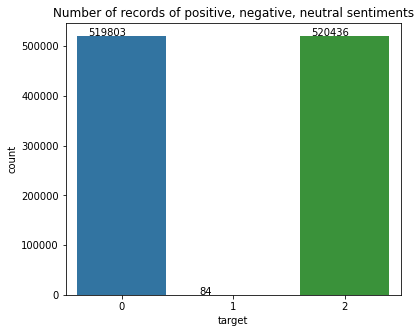

In [10]:
plt.figure(figsize=(6,5))
plt.title("Number of records of positive, negative, neutral sentiments")
plot = sn.countplot(x = 'target', data=train_result_df)
for p in plot.patches:
    plot.annotate(p.get_height(),(p.get_x()+0.1 ,p.get_height()+50))

In [11]:
nltk.download("wordnet")
nltk.download('omw-1.4')
lemmatizer = WordNetLemmatizer()

def text_preprocessing(df):
    #1) Expand contractions in Text Processing
    df['reviews_text']=df['text'].apply(lambda x:contractions.fix(x, slang=True))
    #2) Lower Case
    df['reviews_text'] = df['reviews_text'].str.lower()
    #3) Remove punctuations
    df['reviews_text'] = df['reviews_text'].apply(lambda x: re.sub('[%s]' % re.escape(string.punctuation), '' , x))
    #4) Remove words containing digits
    df['reviews_text'] = df['reviews_text'].apply(lambda x: re.sub(r'\w*\d\w*', '', x))
    #5) Remove Stopwords
    #def remove_stopwords(text):
    #    return " ".join([word for word in str(text).split() if word not in stop_words])
    #df['reviews_text'] = df['reviews_text'].apply(lambda x: remove_stopwords(x))
    #6) Lemmatization
    def lemmatize_words(text):
        return " ".join([lemmatizer.lemmatize(word) for word in text.split()])
    df['reviews_text'] = df['reviews_text'].apply(lambda text: lemmatize_words(text))
    #7) Remove Extra Spaces
    df['reviews_text'] = df['reviews_text'].apply(lambda x: re.sub(' +', ' ', x))
    return df

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


In [12]:
train_df_pre = text_preprocessing(train_df)
test_df_pre = text_preprocessing(test_df)

In [13]:
#preprocessed text
train_df_pre.head(5)

,text,reviews_text
0,Anyway Im getting of for a while,anyway i am getting of for a while
1,"My red, Apache isn't feelin too well this morn...",my red apache is not feelin too well this morning
2,@danyelljoy you should be its great. friday w...,danyelljoy you should be it great friday will ...
3,its 11:30pm and i dont wanna sleep; so i debat...,it and i do not want to sleep so i debated wit...
4,Why does twitter eat my DM's? Not happy,why doe twitter eat my dm not happy


In [14]:
test_df_pre.head(5)

,text,reviews_text
0,so cut... missed out on all the TCE EXTREME ME...,so cut missed out on all the tce extreme merch...
1,Thank you very much Wasin this is awesome lol,thank you very much wasin this is awesome lol
2,Squeezing in some internet time before Dustin ...,squeezing in some internet time before dustin ...
3,@fanoou; Oh i do have moral but i'm gonna be b...,fanoou oh i do have moral but i am going to be...
4,@NSuissa I just bought Sammy some joint/hip ...,nsuissa i just bought sammy some jointhip supp...


Access to the raw dataset iterators 

In [15]:
train_target_iter = iter(train_result_df.target)
train_text_iter = iter(train_df_pre.reviews_text)
#first trans dataframe to iter type dataset
train_iter = zip(train_target_iter,train_text_iter)
test_iter = iter(test_df_pre.reviews_text)

#second tran iter type dataset to map style data_set
#map style dataset can be reuse
train_dataset = to_map_style_dataset(train_iter)
test_dataset = to_map_style_dataset(test_iter)

# Prepare data processing pipelines

In [16]:
tokenizer = get_tokenizer('basic_english')
def yield_tokens(data_iter):
    for _,text in data_iter:
        yield tokenizer(text)

vocab = build_vocab_from_iterator(yield_tokens(train_dataset), specials=["<unk>"])
vocab.set_default_index(vocab["<unk>"])


In [17]:
text_pipeline = lambda x: vocab(tokenizer(x))
#label_pipeline = lambda x: int(x) - 1

In [18]:
print(vocab(['here', 'is', 'an', 'example']))
print(text_pipeline('here is an example'))
#print(label_pipeline('10'))

[84, 5, 88, 3457]
[84, 5, 88, 3457]


# Generate data batch and iterator

In [19]:
#use gpu if possible
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

#for train set
def collate_batch(batch):
    label_list, text_list, offsets = [], [], [0]
    for (_label, _text) in batch:
         label_list.append(_label)
         processed_text = torch.tensor(text_pipeline(_text), dtype=torch.int64)
         text_list.append(processed_text)
         offsets.append(processed_text.size(0))
    label_list = torch.tensor(label_list, dtype=torch.int64)
    offsets = torch.tensor(offsets[:-1]).cumsum(dim=0)
    text_list = torch.cat(text_list)
    return label_list.to(device), text_list.to(device), offsets.to(device)

#for test set
def collate_batch_fortest(batch):
    text_list, offsets = [], [0]
    for _text in batch:
         processed_text = torch.tensor(text_pipeline(_text), dtype=torch.int64)
         text_list.append(processed_text)
         offsets.append(processed_text.size(0))
    offsets = torch.tensor(offsets[:-1]).cumsum(dim=0)
    text_list = torch.cat(text_list)
    return text_list.to(device), offsets.to(device)


# Define the model NN

In [30]:
class TextClassificationModel(nn.Module):

    def __init__(self, vocab_size, embed_dim, num_class):
        super(TextClassificationModel, self).__init__()
        self.embedding = nn.EmbeddingBag(vocab_size, embed_dim, sparse=True)
        self.fc = nn.Linear(embed_dim, num_class)
        self.init_weights()

    def init_weights(self):
        initrange = 0.5
        self.embedding.weight.data.uniform_(-initrange, initrange)
        self.fc.weight.data.uniform_(-initrange, initrange)
        self.fc.bias.data.zero_()

    def forward(self, text, offsets):
        embedded = self.embedding(text, offsets)
        
        return self.fc(embedded)

# Initiate an instance for NN

In [31]:
#for NN
num_class = 3
vocab_size = len(vocab)
emsize = 64
model = TextClassificationModel(vocab_size, emsize, num_class).to(device)

# Define functions to train the model and evaluate results.

In [32]:
def train(dataloader):
    model.train()
    total_acc, total_count = 0, 0
    log_interval = 500
    start_time = time.time()

    for idx, (label, text, offsets) in enumerate(dataloader):
        optimizer.zero_grad()
        predicted_label = model(text, offsets)

        #print(len(predicted_label))
        #print(len(label))
        #print(label)
        #print(predicted_label)

        loss = criterion(predicted_label, label)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 0.1)
        optimizer.step()
        total_acc += (predicted_label.argmax(1) == label).sum().item()
        total_count += label.size(0)
        if idx % log_interval == 0 and idx > 0:
            elapsed = time.time() - start_time
            print('| epoch {:3d} | {:5d}/{:5d} batches '
                  '| accuracy {:8.3f}'.format(epoch, idx, len(dataloader),
                                              total_acc/total_count))
            total_acc, total_count = 0, 0
            start_time = time.time()

def evaluate(dataloader):
    model.eval()
    total_acc, total_count = 0, 0

    with torch.no_grad():
        for idx, (label, text, offsets) in enumerate(dataloader):
            predicted_label = model(text, offsets)
            loss = criterion(predicted_label, label)
            total_acc += (predicted_label.argmax(1) == label).sum().item()
            total_count += label.size(0)
    return total_acc/total_count

# Hyperparameters

In [33]:
# Hyperparameters
EPOCHS = 15 # epoch
LR = 0.1  # learning rate
BATCH_SIZE = 64 # batch size for training

criterion = torch.nn.CrossEntropyLoss().to(device)
optimizer = torch.optim.SGD(model.parameters(), lr=LR)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 1.0, gamma=0.1)

# Split the dataset and run the model

In [34]:
#split train valid set
num_train = int(len(train_dataset) * 0.80)
split_train_, split_valid_ = random_split(train_dataset, [num_train, len(train_dataset) - num_train])
#get pytorch dataloader 
train_dataloader = DataLoader(split_train_, batch_size=BATCH_SIZE,
                              shuffle=True, collate_fn=collate_batch)
valid_dataloader = DataLoader(split_valid_, batch_size=BATCH_SIZE,
                              shuffle=True, collate_fn=collate_batch)
test_dataloader = DataLoader(test_dataset, shuffle=False, collate_fn=collate_batch_fortest)

print(len(split_train_))
print(len(split_valid_))
len(train_dataloader)

832258
208065


13005

# run the model NN

In [35]:
total_accu = 0
for epoch in range(1, EPOCHS + 1):
    epoch_start_time = time.time()
    train(train_dataloader)
    accu_val = evaluate(valid_dataloader)
    if total_accu is not None and total_accu > accu_val:
      scheduler.step()
    else:
       total_accu = accu_val
    print('-' * 59)
    print('| end of epoch {:3d} | time: {:5.2f}s | '
          'valid accuracy {:8.3f} '.format(epoch,
                                           time.time() - epoch_start_time,
                                           accu_val))
    print('-' * 59)

| epoch   1 |   500/13005 batches | accuracy    0.569
| epoch   1 |  1000/13005 batches | accuracy    0.615
| epoch   1 |  1500/13005 batches | accuracy    0.640
| epoch   1 |  2000/13005 batches | accuracy    0.646
| epoch   1 |  2500/13005 batches | accuracy    0.659
| epoch   1 |  3000/13005 batches | accuracy    0.669
| epoch   1 |  3500/13005 batches | accuracy    0.678
| epoch   1 |  4000/13005 batches | accuracy    0.688
| epoch   1 |  4500/13005 batches | accuracy    0.692
| epoch   1 |  5000/13005 batches | accuracy    0.697
| epoch   1 |  5500/13005 batches | accuracy    0.700
| epoch   1 |  6000/13005 batches | accuracy    0.706
| epoch   1 |  6500/13005 batches | accuracy    0.715
| epoch   1 |  7000/13005 batches | accuracy    0.711
| epoch   1 |  7500/13005 batches | accuracy    0.718
| epoch   1 |  8000/13005 batches | accuracy    0.719
| epoch   1 |  8500/13005 batches | accuracy    0.726
| epoch   1 |  9000/13005 batches | accuracy    0.731
| epoch   1 |  9500/13005 ba

In [ ]:
def pred_test(dataloader):
    pred_labels_list = []
    total_acc, total_count = 0, 0

    with torch.no_grad():
        for idx, (text, offsets) in tqdm(enumerate(dataloader)):
            #print(idx)
            predicted_label = model(text, offsets)
            pred_labels_list.append(predicted_label.argmax(1))
    pred_labels = torch.stack(pred_labels_list, 0)
    return pred_labels

In [ ]:
pred_labels = pred_test(test_dataloader)

560175it [02:23, 3906.92it/s]


In [ ]:
df_submit = pd.DataFrame(pred_labels, columns = ['target'])
df_submit = df_submit.reset_index()
df_submit['target'] = df_submit['target'].astype("int")
df_submit.rename(columns={'index':'id'}, inplace = True)

In [ ]:
df_submit.to_csv('./NN1.csv', index = False)

# Try RNN

In [ ]:
class RNN(nn.Module):
    def __init__(self, vocab_size, embed_dim, hidden_dim, output_dim):
        super().__init__()        
        self.embedding = nn.EmbeddingBag(vocab_size, embed_dim, sparse=True)     
        self.rnn = nn.RNN(embed_dim, hidden_dim)       
        self.fc = nn.Linear(hidden_dim, output_dim)

    def init_weights(self):
        initrange = 0.5
        self.embedding.weight.data.uniform_(-initrange, initrange)
        self.fc.weight.data.uniform_(-initrange, initrange)
        self.fc.bias.data.zero_()
        
    def forward(self, text, offsets):
        #text = [sent len, batch size]       
        embedded = self.embedding(text, offsets)      
        #print(embedded.shape)
        #embedded = [sent len, batch size, emb dim]        
        output, hidden = self.rnn(embedded)
        #print(output.shape)    
        #print(hidden.shape)  
        #output = [sent len, batch size, hid dim]
        #hidden = [1, batch size, hid dim]      
        #assert torch.equal(output[-1,:,:], hidden.squeeze(0))# [1, batch size, hid dim] -> [batch size, hid dim]
        
        return self.fc(output)

In [ ]:
#rnn

INPUT_DIM = len(vocab)
EMBEDDING_DIM = 64
HIDDEN_DIM = 256
OUTPUT_DIM = 3

model = RNN(INPUT_DIM, EMBEDDING_DIM, HIDDEN_DIM, OUTPUT_DIM).to(device)

# Hyperparameters
EPOCHS = 5 # epoch
LR = 5  # learning rate
BATCH_SIZE = 64 # batch size for training

criterion = torch.nn.CrossEntropyLoss().to(device)
optimizer = torch.optim.SGD(model.parameters(), lr=LR)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 1.0, gamma=0.1)

In [ ]:
#split train valid set
num_train = int(len(train_dataset) * 0.80)
split_train_, split_valid_ = random_split(train_dataset, [num_train, len(train_dataset) - num_train])
#get pytorch dataloader 
train_dataloader = DataLoader(split_train_, batch_size=BATCH_SIZE,
                              shuffle=True, collate_fn=collate_batch)
valid_dataloader = DataLoader(split_valid_, batch_size=BATCH_SIZE,
                              shuffle=True, collate_fn=collate_batch)
test_dataloader = DataLoader(test_dataset, shuffle=False, collate_fn=collate_batch_fortest)

print(len(split_train_))
print(len(split_valid_))
len(train_dataloader)

832258
208065


13005

In [ ]:
total_accu = 0
for epoch in range(1, EPOCHS + 1):
    epoch_start_time = time.time()
    train(train_dataloader)
    accu_val = evaluate(valid_dataloader)
    if total_accu is not None and total_accu > accu_val:
      scheduler.step()
    else:
       total_accu = accu_val
    print('-' * 59)
    print('| end of epoch {:3d} | time: {:5.2f}s | '
          'valid accuracy {:8.3f} '.format(epoch,
                                           time.time() - epoch_start_time,
                                           accu_val))
    print('-' * 59)

| epoch   1 |   500/13005 batches | accuracy    0.790
| epoch   1 |  1000/13005 batches | accuracy    0.791
| epoch   1 |  1500/13005 batches | accuracy    0.795
| epoch   1 |  2000/13005 batches | accuracy    0.787
| epoch   1 |  2500/13005 batches | accuracy    0.793
| epoch   1 |  3000/13005 batches | accuracy    0.789
| epoch   1 |  3500/13005 batches | accuracy    0.789
| epoch   1 |  4000/13005 batches | accuracy    0.790
| epoch   1 |  4500/13005 batches | accuracy    0.791
| epoch   1 |  5000/13005 batches | accuracy    0.788
| epoch   1 |  5500/13005 batches | accuracy    0.791
| epoch   1 |  6000/13005 batches | accuracy    0.788
| epoch   1 |  6500/13005 batches | accuracy    0.786
| epoch   1 |  7000/13005 batches | accuracy    0.791
| epoch   1 |  7500/13005 batches | accuracy    0.796
| epoch   1 |  8000/13005 batches | accuracy    0.792
| epoch   1 |  8500/13005 batches | accuracy    0.790
| epoch   1 |  9000/13005 batches | accuracy    0.794
| epoch   1 |  9500/13005 ba